<a href="https://colab.research.google.com/github/limshaocong/analyticsEdge/blob/main/Prediction_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Libraries & Data Import Functions**

In [1]:
suppressMessages(library(tidyverse)) # generic must have package
library(dplyr)
library(ggplot2) # plotting package
library(lubridate) # easy comprehension of dates from string to correct datetime format
library(data.table)
library(purrr) # reduce
if("caret" %in% rownames(installed.packages()) == FALSE) {install.packages("caret")}
library(caret)
if("psych" %in% rownames(installed.packages()) == FALSE) {install.packages("psych")}
library(psych) # unscaling
if("padr" %in% rownames(installed.packages()) == FALSE) {install.packages("padr")}
library(padr)
if("janitor" %in% rownames(installed.packages()) == FALSE) {install.packages("janitor")}
library(janitor)

options(repr.plot.width = 9,
        repr.plot.height = 6,
        repr.plot.pointsize = 20)

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”

Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union



Attaching package: ‘data.table’


The following objects are masked from ‘package:lubridate’:

    hour, isoweek, mday, minute, month, quarter, second, wday, week,
    yday, year


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following object is masked from ‘package:purrr’:

    transpose


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘listenv’, ‘parallelly’, ‘future’, ‘globals’, ‘future.apply’, ‘progressr’, ‘numDeriv’, ‘SQUAREM’, ‘lava’, ‘prodlim’, ‘proxy’, ‘iterators’, ‘gower’, ‘ipred’, ‘timeDate’, ‘e1071’, ‘foreach’, ‘ModelMetrics’, ‘plyr’, ‘pROC’, ‘recipes’, ‘reshape2’


Loading required package: lattice


Attaching package: ‘caret’


The followi

Using the following functions to extract the daily trading data, twitter sentiment analysis, r/wsb sentiment analysis and news sentiment analysis. Thereafter, left-joining the data to daily trading data by ticker-date pairs to reduce the entire dataset down to trading days only.

In [216]:
git.path = "https://raw.githubusercontent.com/limshaocong/analyticsEdge/main/Datasets/"

# Prices
# Source: CRSP

price.path = "CRSP_WRDS/crsp_daily_stock_price_2020.csv"

get.prices <- function(tickerlist) {

  path = paste0(git.path, price.path)

  df = read.csv(path) %>%
    filter(ticker %in% tickerlist) %>%
    mutate(date = ymd(date)) %>%
    rename(low = BIDLO,
          high = ASKHI,
          open = OPENPRC,
          close = PRC,
          vol = VOL,
          Ntrades = NUMTRD) %>%
    select(ticker, date, open, close, high, low) %>%
    mutate(change = close - open,
          dayspread = high - low)
}

# Twitter Sentiment Analysis
# Source: Open source
# Scrapped by snscrape
# Sentiment Analysis by BERT - zer0-shot, multilingual, sentiment model

twtr.path = "Imputed/twitter_sa.csv"

get.twitter.sa <- function (tickerlist){
  path = paste0(git.path, twtr.path)
  
  df = read.csv(path) %>%
    filter(ticker %in% tickerlist) %>%
    mutate(date = as.Date(date, format = "%m/%d/%y")) %>%
    mutate(twtrlog10mentions = log10(mentions + 1)) %>%
    select(ticker, date, twtrlog10mentions, twtrsentiment)
}

# r/wsb Sentiment Analysis
# Source: Quiver Quant
# Sentiment based on VADER sentiment

wsb.path = "Imputed/wsb_imputed_min0.csv"

get.wsb.sa <- function(tickerlist){

  path = paste0(git.path, wsb.path)

  df = read.csv(path) %>%
    filter(Ticker %in% tickerlist) %>%
    mutate(date = ymd(Date)) %>%
    pad(start_val = as.Date('2020-01-01'), end_val = as.Date('2020-12-31')) %>%
    rename(wsbsentiment = Sentiment,
          wsblog10mentions = log10Mentions) %>%
    select(Ticker, Date, wsblog10mentions, wsbsentiment) %>%
    rename_with(tolower)
}

# News Sentiment - Dow Jones + Global Press

pr.path = "Imputed/rp_imputed_min500.csv"

get.news.sa <- function(tickerlist){

  path = paste0(git.path, pr.path)

  df = read.csv(path) %>%
    filter(Date >= as.Date("2020-01-01") & Date <= as.Date("2020-12-31")) %>%
    filter(ticker %in% tickerlist) %>%
    mutate(date = ymd(Date)) %>%
    rowwise() %>%
    mutate(newssentiment = mean(DJ_mean_ess * DJ_news_instance, PR_mean_ess * PR_news_instance)/All_news_instance) %>%
    replace(is.na(.), 0) %>%
    mutate(newssentiment = (newssentiment-50)/100) %>%
    rename(newslog10mentions = log10Allmentions) %>%
    select(ticker, Date, newssentiment, newslog10mentions) %>%
    rename_with(tolower)
}

# Compile all data
# Left join to prices df retaining only trading days

get.all.data <- function(tickerlist) {

  prices = get.prices(tickerlist)
  prices$date = as.Date(prices$date)

  wsb.sa = get.wsb.sa(tickerlist)
  wsb.sa$date = as.Date(wsb.sa$date)

  news.sa = get.news.sa(tickerlist)
  news.sa$date = as.Date(news.sa$date)

  twitter.sa = get.twitter.sa(tickerlist)
  twitter.sa$date = as.Date(twitter.sa$date)

  df = list(prices, wsb.sa, news.sa, twitter.sa) %>%
            reduce(left_join, by = c("ticker", "date"))
}

check.missing.data <- function(df) {
  complete.row = sum(complete.cases(df))
  actual.row = dim(df)[1]

  if(complete.row == actual.row) {
    print("No missing data")
  } else {
    print("Missing data present")
  }
}

In [217]:
tickerlist = list("MSFT")

imported_df = get.all.data(tickerlist) %>%
  arrange(ticker, date)

ticker.count = length(unique(imported_df[["ticker"]]))

check.missing.data(imported_df)

pad applied on the interval: day



[1] "No missing data"


In [219]:
head(imported_df)

,ticker,date,open,close,high,low,change,dayspread,wsblog10mentions,wsbsentiment,newssentiment,newslog10mentions,twtrlog10mentions,twtrsentiment
,<chr>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,MSFT,2020-01-02,158.780,160.62,160.730,158.3300,1.84000,2.40000,1.579784,0.058202703,-0.50000000,0.0000000,2.559907,0.3895028
2,MSFT,2020-01-03,158.320,158.62,159.945,158.0600,0.29999,1.88501,1.579784,-0.009467568,-0.50000000,0.0000000,2.372912,0.4085106
3,MSFT,2020-01-06,157.080,159.03,159.100,156.5100,1.95000,2.59002,1.230449,-0.070725000,-0.50000000,0.4771213,2.378398,0.3781513
4,MSFT,2020-01-07,159.320,157.58,159.670,157.3200,-1.74001,2.34999,1.623249,-0.090526829,-0.50000000,0.4771213,2.440909,0.2218182
5,MSFT,2020-01-08,158.930,160.09,160.800,157.9491,1.16001,2.85090,1.643453,-0.111018605,0.35000000,0.4771213,2.539076,0.4231884
6,MSFT,2020-01-09,161.835,162.09,162.215,161.0300,0.25499,1.18500,1.579784,0.065070270,0.02272727,1.0791812,2.610660,0.2948403


# **(Slight) Feature Engineering**

In [238]:
# Add in target variable

df = imported_df %>%
  group_by(ticker) %>%
  mutate(target = lead(close, n = 1, default = NA)) %>% # target using by taking the $close of the next period
  mutate(prevclose1 = lag(close, n = 1, default = NA), # additional variables by lagging earlier $close
         prevclose2 = lag(close, n = 2, default = NA), # in log2 scale, kaggle trick
         prevclose4 = lag(close, n = 4, default = NA),
         prevclose8 = lag(close, n = 8, default = NA)) %>%
  mutate(prevwsbsentiment1 = lag(wsbsentiment, n = 1, default = NA), # additional variables by lagging earlier $wsbsentiment
         prevwsbsentiment2 = lag(wsbsentiment, n = 2, default = NA), # in log2 scale, kaggle trick
         prevwsbsentiment4 = lag(wsbsentiment, n = 4, default = NA),
         prevwsbsentiment8 = lag(wsbsentiment, n = 8, default = NA)) %>%
  mutate(prevnewssentiment1 = lag(newssentiment, n = 1, default = NA), # additional variables by lagging earlier $newssentiment
         prevnewssentiment2 = lag(newssentiment, n = 2, default = NA), # in log2 scale, kaggle trick
         prevnewssentiment4 = lag(newssentiment, n = 4, default = NA),
         prevnewssentiment8 = lag(newssentiment, n = 8, default = NA)) %>%
  mutate(prevtwtrsentiment1 = lag(twtrsentiment, n = 1, default = NA), # additional variables by lagging earlier $twtrsentiment
         prevtwtrsentiment2 = lag(twtrsentiment, n = 2, default = NA), # in log2 scale, kaggle trick
         prevtwtrsentiment4 = lag(twtrsentiment, n = 4, default = NA),
         prevtwtrsentiment8 = lag(twtrsentiment, n = 8, default = NA)) %>%
  na.omit %>%
  as.data.frame() %>%
  relocate(target, .after = last_col())

In [195]:
""""
# Do scaling of all variables
# Retain means and sd for unscaling of data

scaling.mean = colMeans(df[sapply(df, is.numeric)])
scaling.sd = sapply(df[sapply(df, is.numeric)], sd)

df[map_lgl(df, is.numeric)] = df %>%
                              select(is.numeric) %>%
                              scale(center = scaling.mean, scale = scaling.sd)
"""

In [128]:
"""
# One-hot encoding for ticker

if (ticker.count > 1){
  dummy = dummyVars(" ~ .", data = df)
  df = data.frame(predict(dummy, newdata = df))
} 
"""

ERROR: ignored

Final check for missing data before model training

In [239]:
check.missing.data(df)

[1] "No missing data"


# **Train-Validate-Test Split**



In [240]:
split = unclass(as.Date("2020-09-30"))

# Train-test split
train = df %>% filter(date < split)
test = df %>% filter(date >= split)

train.days = dim(train)[1]/ticker.count
test.days = dim(test)[1]/ticker.count

train.prop = train.days/(train.days + test.days)

print("% of Training Data")
print(train.prop)
print(train.days)

[1] "% of Training Data"
[1] 0.7377049
[1] 180


This splitting of train-validate only serves as an illustration. The real splitting is embedded in the training process as per normal CV. However, as normal k-fold CV does not work on time series data due to the emphasis its temporal features, a sliding window approach is used (see Section 4.3 of https://topepo.github.io/caret/data-splitting.html#time)

In [241]:
# In this instance, with 180 days worh of data, there are 6 folds based on the chosen parameters

index = 1:train.days
folds = createTimeSlices(index, initialWindow = 95, horizon = 30, fixedWindow = TRUE, skip = 10)
lapply(folds, length)

$train
[1] 6

$test
[1] 6

Sample of how the folds are constructed is as follows.

In [242]:
folds$train
folds$test

$Training095
 [1]  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
[26] 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50
[51] 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75
[76] 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95

$Training106
 [1]  12  13  14  15  16  17  18  19  20  21  22  23  24  25  26  27  28  29  30
[20]  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47  48  49
[39]  50  51  52  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68
[58]  69  70  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87
[77]  88  89  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106

$Training117
 [1]  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37  38  39  40  41
[20]  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57  58  59  60
[39]  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78  79
[58]  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98
[77]  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117

$Training128
 [1]  34  35  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52
[20]  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
[39]  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
[58]  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109
[77] 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128

$Training139
 [1]  45  46  47  48  49  50  51  52  53  54  55  56  57  58  59  60  61  62  63
[20]  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80  81  82
[39]  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99 100 101
[58] 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120
[77] 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139

$Training150
 [1]  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74
[20]  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93
[39]  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112
[58] 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131
[77] 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150

$Testing095
 [1]  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114
[20] 115 116 117 118 119 120 121 122 123 124 125

$Testing106
 [1] 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
[20] 126 127 128 129 130 131 132 133 134 135 136

$Testing117
 [1] 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136
[20] 137 138 139 140 141 142 143 144 145 146 147

$Testing128
 [1] 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147
[20] 148 149 150 151 152 153 154 155 156 157 158

$Testing139
 [1] 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158
[20] 159 160 161 162 163 164 165 166 167 168 169

$Testing150
 [1] 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169
[20] 170 171 172 173 174 175 176 177 178 179 180

# **Model Building and Selection**

In [243]:
library(rpart)
if("rpart.plot" %in% rownames(installed.packages()) == FALSE) {install.packages("rpart.plot")}
library(rpart.plot)
if("Metrics" %in% rownames(installed.packages()) == FALSE) {install.packages("Metrics")}
library(Metrics)

In [245]:
str(train)

'data.frame':	180 obs. of  31 variables:
 $ ticker            : chr  "MSFT" "MSFT" "MSFT" "MSFT" ...
 $ date              : Date, format: "2020-01-14" "2020-01-15" ...
 $ open              : num  163 163 164 167 167 ...
 $ close             : num  162 163 166 167 166 ...
 $ high              : num  164 164 166 167 168 ...
 $ low               : num  162 163 164 165 166 ...
 $ change            : num  -1.26 0.56 1.82 -0.32 -0.18 ...
 $ dayspread         : num  1.88 1.37 2.21 2.04 1.76 ...
 $ wsblog10mentions  : num  1.34 1.26 1.74 2.06 1.72 ...
 $ wsbsentiment      : num  0.168395 0.123718 0.147098 0.073684 -0.000337 ...
 $ newssentiment     : num  -0.0783 0.14 0.024 -0.5 0.1475 ...
 $ newslog10mentions : num  0.845 0.699 0.778 0 0.699 ...
 $ twtrlog10mentions : num  2.53 2.44 2.64 2.73 2.49 ...
 $ twtrsentiment     : num  0.202 0.274 0.376 0.324 0.255 ...
 $ prevclose1        : num  163 162 163 166 167 ...
 $ prevclose2        : num  161 163 162 163 166 ...
 $ prevclose4        : num  

In [246]:
ticker.train = train %>% filter (ticker == "MSFT")
trainX = ticker.train[, c(3:30)]
trainY = ticker.train$target

ticker.test = test %>% filter (ticker == "MSFT")
testX = ticker.test[, c(3:30)]
testY = ticker.test$target

In [269]:
smape(ticker.test$pred, ticker.test$close)

[1] 0.01694771

##**CART**

In [259]:
train.control = trainControl(method = "timeslice",
                            initialWindow = 95,
                            horizon = 30,
                            fixedWindow = TRUE)

cpVals = data.frame(.cp = seq(0.001, 0.002, by = 0.0001))

mod = train(x = trainX,
            y = trainY,
            method = "rpart",
            trControl = train.control,
            tuneGrid = cpVals)

Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


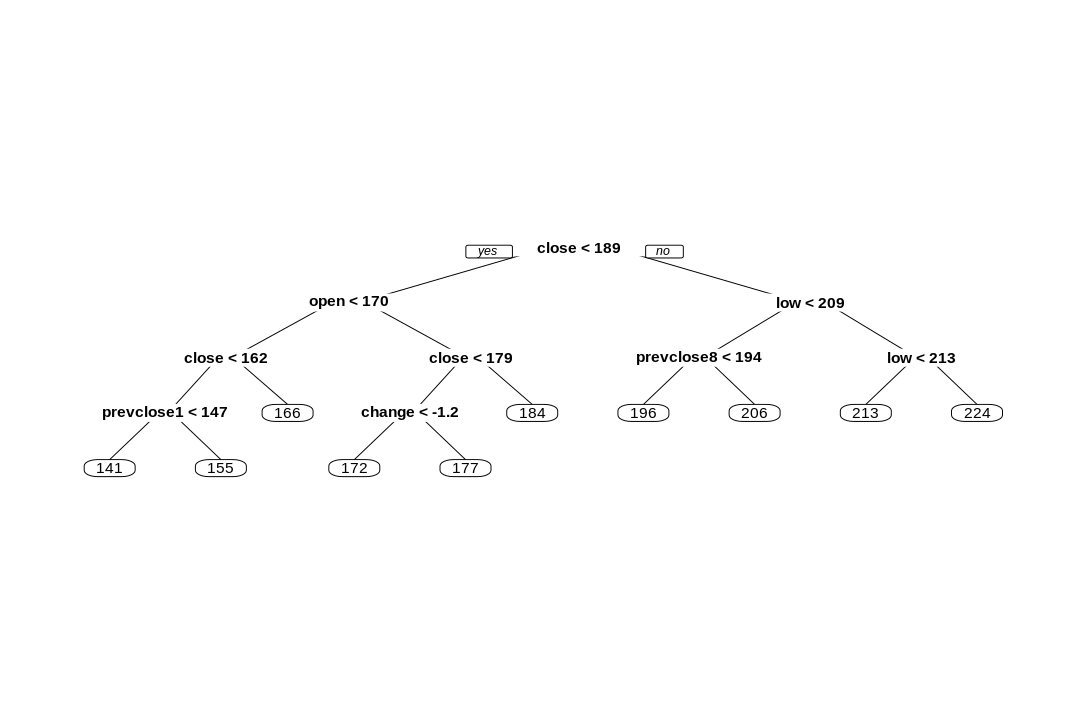

In [260]:
prp(mod$finalModel)

In [264]:
mod$modelType
mod$bestTune

[1] "Regression"

,cp
,<dbl>
5,0.0014


In [270]:
ticker.train$pred = predict(object = mod$finalModel, newdata = trainX)
ticker.test$pred = predict(object = mod$finalModel, newdata = testX)

In [271]:
print("train")
print(smape(ticker.train$target, ticker.train$pred))
print("test")
print(smape(ticker.test$target, ticker.test$pred))

[1] "train"
[1] 0.01625947
[1] "test"
[1] 0.02341541


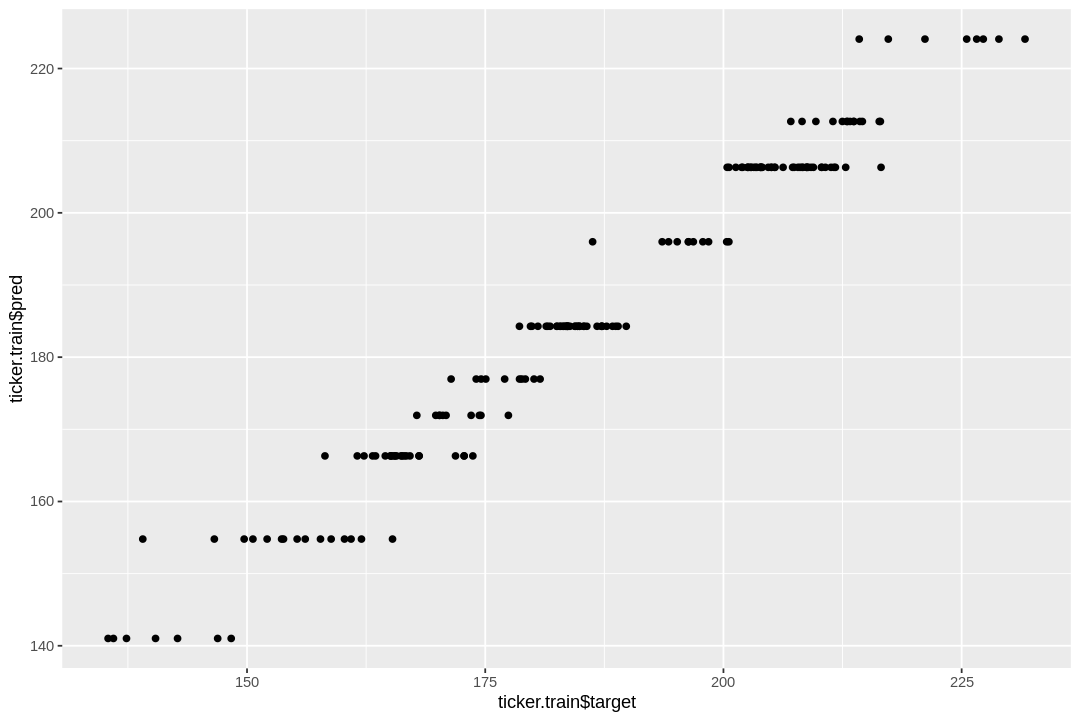

In [267]:
ggplot() +
geom_point(aes(x = ticker.train$target, y = ticker.train$pred))